# Harmonize ONT reads with array reference

1. Converting CRAM to FASTQ (or basecall straight into fastq and skip this step):

    `samtools bam2fq -@ 32 -T 1 --reference ./ref/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna cram/uf_hembank_1832.pass.cram > fastq/output.fq.gz`
    

2. Minimap2 aligment:

    `minimap2 -y -t 32 -ax lr:hq ref/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna fastq/uf_hembank_1832.fq.gz > sam/uf_hembank_1832.sam`

3. Converting SAM to BAM, sorting, and indexing:

    a. Convert SAM to BAM:

    `samtools view -@ 32 -bS output.sam > output.bam`

    b. Sort BAM:

    `samtools sort -@ 32 output.bam -o sorted_output.bam`

    c. Create BAM Index:

    `samtools index sorted_output.bam`

    or combine b and c:

    `samtools sort -@ 32 bam/uf_hembank_1832.bam --write-index -o bam/sorted_output_1832.bam -O BAM --reference ref/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna`

4. Modkit
    
    `modkit pileup bam/sorted_output_1832.bam bed/uf_hembank_1832_pacmap_trad.bed -t 32 --combine-strands --cpg --ignore h --ref ref/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna`


## Where data at?

In [1]:
import pandas as pd

mount = '/mnt/d/'

reference_path = mount + 'genome_references/Illumina_methylation_arrays/EPIC.hg38.manifest.tsv.gz'
output_path = mount + 'MethylScore_v2/Processed_Data/'

sample_name = 'uf_hembank_1832'

## Create BED6 file to harmonize probes from EPIC array with nanopore

In [150]:
# read df_discovery and df_validation
df_discovery = pd.read_pickle(mount+'MethylScore_v2/Intermediate_Files/'+'3308samples_333059cpgs_withbatchcorrection_bvalues.pkl').sort_index().iloc[:,1:]

array_reference = pd.read_csv("/mnt/c/Users/fmarc/OneDrive/Desktop/nanopore_processed/ref/EPIC.hg38.manifest.gencode.v36.tsv.gz", sep='\t', compression='gzip',
                              usecols=['CpG_chrm','CpG_beg','CpG_end','probe_strand','probeID']
                              ).set_index('probeID').sort_index()

In [151]:
pacmap_reference = array_reference.loc[df_discovery.columns].reset_index()

# remove `.0` from `CpG_beg` and `CpG_end` and coordinate
pacmap_reference['CpG_beg'] = pacmap_reference['CpG_beg'].astype(int)
pacmap_reference['CpG_end'] = pacmap_reference['CpG_end'].astype(int)
pacmap_reference['score'] = 0

pacmap_reference = pacmap_reference[['CpG_chrm','CpG_beg','CpG_end','IlmnID','score','probe_strand']]
pacmap_reference = pacmap_reference.rename(columns={'CpG_chrm':'chrom','CpG_beg':'chromStart','CpG_end':'chromEnd','IlmnID':'name','probe_strand':'strand'})

# sort by chromosome and start
pacmap_reference = pacmap_reference.sort_values(by=['chrom','chromStart'])

pacmap_reference.to_csv('/mnt/c/Users/fmarc/OneDrive/Desktop/nanopore_processed/ref/pacmap_reference.bed', sep='\t', index=False, header=False)

In [2]:
# read the bed file
pacmap_reference = pd.read_csv('/mnt/c/Users/fmarc/OneDrive/Desktop/nanopore_processed/ref/pacmap_reference.bed', sep='\t', header=None, names=['chrom','chromStart','chromEnd','name','score','strand'])
pacmap_reference

,chrom,chromStart,chromEnd,name,score,strand
0,chr1,69590,69592,cg21870274,0,+
1,chr1,864702,864704,cg08258224,0,-
2,chr1,870160,870162,cg16619049,0,-
3,chr1,877158,877160,cg18147296,0,-
4,chr1,898802,898804,cg13938959,0,+
...,...,...,...,...,...,...
333053,chr9,138119084,138119086,cg00378292,0,+
333054,chr9,138120221,138120223,cg07982825,0,-
333055,chr9,138122338,138122340,cg14491707,0,+
333056,chr9,138122548,138122550,cg13811936,0,-


## Load modkit processed file

In [18]:
# # Define columns to be used for the input data
usecols = [0, 1, 4, 10]
column_names = ["chrom", "start_position", "score", "fraction_modified"]

# Read the input data, skipping the first row if it's a header or irrelevant
df = pd.read_csv('/mnt/c/Users/fmarc/OneDrive/Desktop/nanopore_processed/5_bed/uf_hembank_1832_pacmap_trad.bed', sep='\s+', skiprows=1, usecols=usecols, names=column_names)

In [3]:

# Read the input data, skipping the first row if it's a header or irrelevant
df = pd.read_csv('/mnt/c/Users/fmarc/OneDrive/Desktop/nanopore_processed/5_bed/uf_hembank_1832_pacmap_trad.bed', sep='\s+', skiprows=1,
                 names=["chrom", "start_position","end_position","modified base code","score",'strand' ,"start position","end position", "color", "Nvalid_cov", "fraction modified", "Nmod", "Ncanonical", "Nother_mod", "Ndelete", "Nfail", "Ndiff", "Nnocall"
])

In [4]:
df

,chrom,start_position,end_position,modified base code,score,strand,start position,end position,color,Nvalid_cov,fraction modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall
0,chr1,10470,10471,m,2,.,10470,10471,"255,0,0",2,50.00,1,1,0,0,1,0,0
1,chr1,10483,10484,m,2,.,10483,10484,"255,0,0",2,100.00,2,0,0,0,1,0,0
2,chr1,10488,10489,m,3,.,10488,10489,"255,0,0",3,100.00,3,0,0,0,0,0,0
3,chr1,10492,10493,m,3,.,10492,10493,"255,0,0",3,100.00,3,0,0,0,0,0,0
4,chr1,10496,10497,m,3,.,10496,10497,"255,0,0",3,100.00,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28351776,chrUn_GL000218v1,160573,160574,m,8,.,160573,160574,"255,0,0",8,12.50,1,7,0,0,0,1,0
28351777,chrUn_GL000218v1,160611,160612,m,8,.,160611,160612,"255,0,0",8,87.50,7,1,0,0,0,0,0
28351778,chrUn_GL000218v1,160669,160670,m,8,.,160669,160670,"255,0,0",8,25.00,2,6,0,0,0,0,0
28351779,chrUn_GL000218v1,160790,160791,m,8,.,160790,160791,"255,0,0",8,37.50,3,5,0,0,0,0,0


In [5]:

# Create 'coordinate' column for merging
df['coordinate'] = df['chrom'].astype(str) + ':' + df['start_position'].astype(str)

df_filtered = df.set_index('coordinate')

In [6]:
df_filtered

,chrom,start_position,end_position,modified base code,score,strand,start position,end position,color,Nvalid_cov,fraction modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall
coordinate,,,,,,,,,,,,,,,,,,
chr1:10470,chr1,10470,10471,m,2,.,10470,10471,"255,0,0",2,50.00,1,1,0,0,1,0,0
chr1:10483,chr1,10483,10484,m,2,.,10483,10484,"255,0,0",2,100.00,2,0,0,0,1,0,0
chr1:10488,chr1,10488,10489,m,3,.,10488,10489,"255,0,0",3,100.00,3,0,0,0,0,0,0
chr1:10492,chr1,10492,10493,m,3,.,10492,10493,"255,0,0",3,100.00,3,0,0,0,0,0,0
chr1:10496,chr1,10496,10497,m,3,.,10496,10497,"255,0,0",3,100.00,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrUn_GL000218v1:160573,chrUn_GL000218v1,160573,160574,m,8,.,160573,160574,"255,0,0",8,12.50,1,7,0,0,0,1,0
chrUn_GL000218v1:160611,chrUn_GL000218v1,160611,160612,m,8,.,160611,160612,"255,0,0",8,87.50,7,1,0,0,0,0,0
chrUn_GL000218v1:160669,chrUn_GL000218v1,160669,160670,m,8,.,160669,160670,"255,0,0",8,25.00,2,6,0,0,0,0,0


In [7]:
pacmap_reference['coordinate'] = pacmap_reference['chrom'].astype(str) + ':' + pacmap_reference['chromStart'].astype(str)
pacmap_reference = pacmap_reference.set_index('coordinate')

In [12]:
# Join with reference data on 'coordinate'
df_merged = df_filtered.join(pacmap_reference[['name']], how='outer')

In [14]:

# Interpolate missing values in 'fraction modified' column linearly
df_merged['fraction modified'] = df_merged['fraction modified'].astype(float).interpolate(method='linear')


df_merged = df_merged[['fraction modified']].join(pacmap_reference, how='inner').fillna(50)

df_merged = df_merged.drop_duplicates(subset='name')

# Calculate the fraction modified and prepare the final DataFrame
df_merged.loc[:, sample_name] = (df_merged['fraction modified'] / 100).round(3)

df_processed = df_merged[['name', sample_name]].set_index('name').T

## Apply PaCMAP model

In [16]:
import pacmap

def apply_pacmap_model_to_new_data(df, components):

    # Load reducer
    reducer = pacmap.load(f'../models/pacmap_{components}d_model_al_atlas')

    # Project the high dimensional dataset into existing embedding space and return the embedding.
    embedding = reducer.transform(df.to_numpy(dtype='float16'))

    # Create column names
    cols = ['PaCMAP '+ str(i+1) + f' of {components}' for i in range(components)]

    # Turn embedding into dataframe
    df_embedding = pd.DataFrame(embedding, columns=cols, index=df.index)

    return df_embedding

df_embedding_2d = apply_pacmap_model_to_new_data(df_processed, 2)
df_embedding_5d = apply_pacmap_model_to_new_data(df_processed, 5)

df_embedding_2d.to_pickle(output_path + sample_name + '_pacmap_2d.pkl')
df_embedding_5d.to_pickle(output_path + sample_name + '_pacmap_5d.pkl')

## Apply supervised models

In [17]:
import joblib

# Load models
lgbm_px_model = joblib.load('../models/lgbm_px_model.pkl')
lgbm_dx_model = joblib.load('../models/lgbm_dx_model.pkl')

# load `df_embedding_5d` from the previous step
df_embedding_5d = pd.read_pickle(output_path + sample_name + '_pacmap_5d.pkl')

def save_predictions(df, classifier, model_name):

    # ignore sklearn warnings
    import warnings
    warnings.filterwarnings('ignore')

    # Select necessary columns
    df_features = df.copy()

    # Predict using the selected columns
    predictions = classifier.predict(df_features)

    # Predict probabilities using the selected columns
    probabilities = classifier.predict_proba(df_features)

    # Convert predictions to a Series with the same index as df_features
    predictions_series = pd.Series(predictions, index=df_features.index, name=model_name)

    # Convert probabilities to a DataFrame with the same index as df_features and the same columns as the classes
    probabilities_df = pd.DataFrame(probabilities, index=df_features.index, columns=classifier.classes_).round(3)

    # Add " - predict_proba" to the column names
    probabilities_df.columns ='P(' + probabilities_df.columns + ')'

    # Transform classes of the predictions into integers based on unique values in the classes
    probabilities_df[model_name + '_int'] = predictions_series.map({c: i for i, c in enumerate(classifier.classes_)})

    # Join predictions with the original DataFrame (already indexed)
    df_joined = predictions_series.to_frame().join(probabilities_df)

    return df_joined

# Execution
df_pred_px = save_predictions(df=df_embedding_5d, classifier=lgbm_px_model, model_name='AML Epigenomic Risk')
df_pred_dx = save_predictions(df=df_embedding_5d, classifier=lgbm_dx_model, model_name='AL Epigenomic Phenotype')

# Map the classes to more desirable labels (low and high risk)
df_pred_px['AML Epigenomic Risk'] = df_pred_px['AML Epigenomic Risk'].map({'Alive': 'Low', 'Dead': 'High'})
df_pred_px = df_pred_px.rename(columns={'P(Alive)': 'AML Epigenomic Risk P(Low Risk)', 'P(Dead)': 'AML Epigenomic Risk P(High Risk)'})

# Join predictions with clinical data
df_combined = df_embedding_2d.join(df_embedding_5d).join(df_pred_px).join(df_pred_dx)

df_combined[['AML Epigenomic Risk', 'AML Epigenomic Risk P(High Risk)', 'AL Epigenomic Phenotype', f'P({df_combined["AL Epigenomic Phenotype"].item()})']]

,AML Epigenomic Risk,AML Epigenomic Risk P(High Risk),AL Epigenomic Phenotype,P(AML with inv(16); t(16;16); CBFB::MYH11)
uf_hembank_1832,High,0.553,AML with inv(16); t(16;16); CBFB::MYH11,0.604


## EWASCox-Lasso

In [18]:
import math
import sys
sys.path.append('../')
from source.cox_lasso import *

raw_coefs = pd.read_csv(output_path + 'multivariate_cox_lasso/ewas_cog_os_raw_coefs_newrisk.csv', index_col=0)

mean_coefs = set_cutoff(coefs=raw_coefs,threshold=0.99)

df_validation = df_processed[mean_coefs.index]

df_validation_transformed = df_validation.replace(1, 0.999).replace(0, 0.001)

def beta2m(val):
    '''Transfrom beta-values into m-values'''
    return math.log2(val/(1-val))

x_test_m = df_validation_transformed.apply(np.vectorize(beta2m))

def standardize_data(df, reference_df):
    """Standardize data using mean and standard deviation of reference dataset"""

    # Keep only columns that are in both datasets
    reference_df = reference_df.loc[:, df.columns]

    # Standardize data
    df_z = (df - reference_df.mean()) / reference_df.std()

    return df_z

# Read top CpGs selected from previous code file (univariate cox-ph EWAS)
ewas_top_cpgs = pd.read_csv(output_path+'ewas_dmr/ewas_top_cpgs_os.csv', index_col=0)

# Standardize data
x_test_m_z = standardize_data(df= x_test_m, reference_df= ewas_top_cpgs)

score_name = 'EWASCox_OS_48CpGs'

df_test, threshold = generate_coxph_score(coef_mean=mean_coefs,
                                        x=x_test_m_z,
                                        df=df_validation_transformed,
                                        score_name=score_name,
                                        train_test=0.4934,
                                        rpart_outcome='os.time')

df_validation_transformed[['EWASCox_OS_48CpGs','EWASCox_OS_48CpGs Categorical']]

Continuous score cut at the value of 0.4934


name,EWASCox_OS_48CpGs,EWASCox_OS_48CpGs Categorical
uf_hembank_1832,-2.60109,Low


## Save results

In [24]:
df_nanopore = df_combined.join(df_validation_transformed[['EWASCox_OS_48CpGs','EWASCox_OS_48CpGs Categorical']])

df_nanopore['Train-Test'] = 'Long-read Nanopore sequencing'
df_nanopore['Clinical Trial'] = 'UF Hem Bank'
df_nanopore['Patient_ID'] = sample_name
df_nanopore['Hematopoietic Entity'] = np.nan
df_nanopore['WHO 2022 Diagnosis'] =  np.nan
df_nanopore['Vital Status'] = np.nan
df_nanopore['Risk Group AAML1831'] = np.nan

df_nanopore.to_excel(output_path + sample_name + '_processed.xlsx')

# print save message
print(f'Processed data for {sample_name} saved as {output_path + sample_name + "_processed.xlsx"}')

Processed data for uf_hembank_1832 saved as /mnt/d/MethylScore_v2/Processed_Data/uf_hembank_1832_processed.xlsx


## Plots results

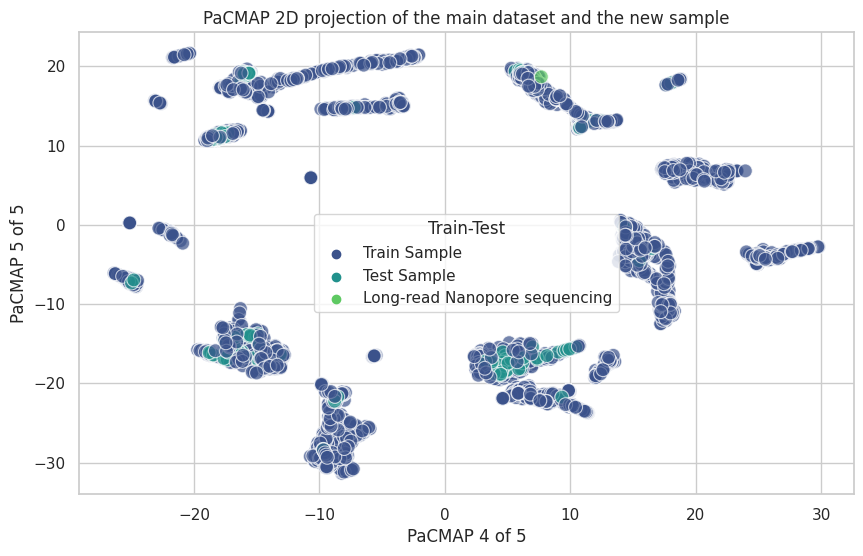

In [33]:
file_path = '../data/al_atlas_main_results.xlsx'
atlas_main = pd.read_excel(file_path, index_col=0).sort_index()          

df2 = pd.concat([atlas_main, df_nanopore])

# plot a scatter plot
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# Create a visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x="PaCMAP 4 of 5", y="PaCMAP 5 of 5", hue="Train-Test", data=df2, palette='viridis', s=100, alpha=0.7)
plt.title('PaCMAP 2D projection of the main dataset and the new sample')
plt.show()

In [23]:
df2

,PaCMAP 1 of 2,PaCMAP 2 of 2,PaCMAP 1 of 5,PaCMAP 2 of 5,PaCMAP 3 of 5,PaCMAP 4 of 5,PaCMAP 5 of 5,Sex,Patient_ID,Age (years),...,P(B-ALL with t(9;22); BCR::ABL1),P(B-ALL with t(v;11q23); KMT2A-r),P(MDS-related; secondary myeloid),P(MPAL B-Lymphoblastic/Myeloid),P(MPAL T-Lymphoblastic/Myeloid),P(Otherwise-Normal Control),P(T-ALL NOS),AL Epigenomic Phenotype_int,EWASCox_OS_48CpGs,EWASCox_OS_48CpGs Categorical
0003fe29-7b8f-4ef1-b9bc-40306205f1fd_noid,10.993684,-23.841497,13.072570,-12.652895,5.383432,17.625345,-12.096922,Male,PANVPB,14.624658,...,0.001,0.001,0.054,0.002,0.003,0.007,0.002,6,NaN,NaN
0031efba-f564-4fff-bd7b-2b97f37218c1_noid,-14.079874,2.579371,1.754884,17.689943,11.464865,7.693504,16.265778,Female,PASDKZ,5.136986,...,0.003,0.006,0.033,0.012,0.004,0.335,0.044,23,NaN,NaN
0037ec75-bb9e-4dbb-a2d9-de1f9bfd2362_noid,24.146299,-13.630013,14.408895,-11.843503,1.639497,-14.958056,-14.530967,Female,PASDKZ,5.136986,...,0.000,0.000,0.002,0.001,0.001,0.010,0.001,2,NaN,NaN
003d9efe-90a1-42cf-84c4-03fbabefe60b_noid,-14.570662,-13.675854,-13.736595,5.045979,-16.469444,-8.745210,-21.688650,NaN,TARGET-00-SJNORM054698,NaN,...,0.002,0.001,0.001,0.006,0.030,0.869,0.002,23,NaN,NaN
004c953f-d999-4d82-898d-c091e692df3c_noid,-28.346189,-11.012460,-15.951436,-3.257456,-3.571518,24.727869,-3.949116,Female,PASAUT,1.542466,...,0.001,0.001,0.010,0.001,0.004,0.034,0.001,7,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe185655-3aa5-4c5c-9dfd-630e0ee71710_noid,-29.790565,24.317287,-12.626092,11.444869,19.171644,3.182598,-18.100124,Female,TCGA-AB-2832,59.000000,...,0.001,0.003,0.014,0.001,0.001,0.001,0.002,11,NaN,NaN
ff7f7d14-5fb7-44bc-b67a-d07610873330_noid,-10.055902,3.307319,-14.923849,-9.447001,0.757874,9.168709,16.290012,Male,TCGA-AB-2831,59.000000,...,0.001,0.001,0.733,0.001,0.001,0.017,0.002,20,NaN,NaN
ff87c237-583a-4aa1-880c-7d77d00ba0a6_noid,5.957821,-12.611219,14.541007,-13.667682,3.962834,15.972788,-2.908703,Female,TCGA-AB-2964,57.000000,...,0.000,0.000,0.866,0.000,0.000,0.002,0.000,20,NaN,NaN
ffeac099-79b4-4fbf-a283-275d31baf531_noid,-32.214596,-7.252369,-14.469069,-0.403573,-0.911309,27.695244,-3.394278,Male,PARFXF,21.054795,...,0.000,0.000,0.003,0.000,0.003,0.918,0.001,23,NaN,NaN


## Watermark

In [88]:
%load_ext watermark

In [90]:
# watermark with all libraries used in this notebook
%watermark -v -p numpy,pandas,pacmap,sklearn,lightgbm -a Francisco_Marchi@Lamba_Lab_UF -d -m

Author: Francisco_Marchi@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.3

numpy   : 1.24.4
pandas  : 2.0.3
pacmap  : 0.7.0
sklearn : 1.2.2
lightgbm: 3.3.5

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.133.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 6
Architecture: 64bit



```{note}
Please only use the following versions:
`python`: 3.8.16
`pacmap`: 0.7.0
`lightgbm`: 3.3.5
`scikit-learn`: 1.2.2
```